# 1 — EDA (Regression)

**Goal:** Understand the data and the continuous target (`accident_risk`).
- Preview
- Target distribution
- Dtypes & missing values
- Numeric vs categorical


In [1]:
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
sys.path.append(os.path.abspath(os.path.join("..", "..")))
from common.prep import load_data, infer_target, split_features



train, test, sample = load_data()
target_col = infer_target(train, test)
feature_cols, cat_cols, num_cols = split_features(train, target_col)
train.shape, test.shape, target_col

((517754, 14), (172585, 13), 'accident_risk')

In [2]:
train.head(10)

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56
5,5,highway,3,0.54,70,night,foggy,True,False,morning,False,True,0,0.61
6,6,highway,1,0.04,45,night,foggy,False,True,morning,True,False,2,0.20
7,7,highway,2,0.33,45,daylight,clear,False,True,evening,False,True,0,0.16
8,8,rural,3,0.63,25,dim,clear,True,False,evening,True,True,2,0.18
9,9,urban,4,0.38,45,dim,clear,True,True,afternoon,True,True,2,0.15


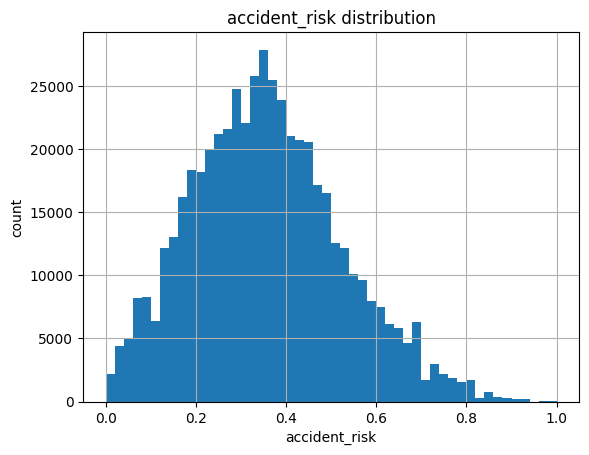

In [3]:
plt.figure()
train[target_col].hist(bins=50)
plt.title('accident_risk distribution')
plt.xlabel('accident_risk')
plt.ylabel('count')
plt.show()

In [4]:
dtypes = train.dtypes.astype(str).rename('dtype')
nulls = train.isna().mean().rename('null_share')
pd.concat([dtypes, nulls], axis=1).head(30)

,dtype,null_share
id,int64,0.0
road_type,object,0.0
num_lanes,int64,0.0
curvature,float64,0.0
speed_limit,int64,0.0
lighting,object,0.0
weather,object,0.0
road_signs_present,bool,0.0
public_road,bool,0.0
time_of_day,object,0.0


In [5]:
print(f'Numeric: {len(num_cols)} | Categorical: {len(cat_cols)}')
print('Numeric sample:', num_cols[:10])
print('Categorical sample:', cat_cols[:10])

Numeric: 9 | Categorical: 4
Numeric sample: ['id', 'num_lanes', 'curvature', 'speed_limit', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'num_reported_accidents']
Categorical sample: ['road_type', 'lighting', 'weather', 'time_of_day']


**Takeaways:** Target is continuous → regression. Use RMSE for evaluation; simple preprocessing (median impute + OHE).